# MIP - CVRP

$$
\begin{align}
    \text{min} \quad & \sum_{k \in K}\sum_{i \in V}\sum_{j \in V} c_{i, j} x_{i, j, k} \\
    \text{s.t} \quad & \sum_{k \in K}\sum_{j \in V} x_{i, j, k} = \sum_{k \in K}\sum_{j \in V} x_{j, i, k} = 1 & \forall \; i \in V \setminus \{0\} \\
    & \sum_{j \in V} x_{i, j, k} = \sum_{j \in V} x_{j, i, k} = y_{i, k} & \forall \; i \in V \setminus \{0\} \; k \in K \\
    & \sum_{i \in V} q_{i} y_{i, k} \leq Q & \forall \; k \in K \\
    & \sum_{k \in K}\sum_{j \in V} x_{0, j, k} = \sum_{k \in K}\sum_{i \in V} x_{i, 0, k} = |K| \\
    & \sum_{i \in S}\sum_{j \notin S} x_{i, j, k} \geq y_{h, k} & \forall \; S \subseteq V \setminus \{0\} \; h \in S \; k \in K \\
    & x_{i, j, k} \in \{0, 1\} & \forall \; i \in V \; j \in V \; k \in K \\
    & y_{i, k} \in \{0, 1\} & \forall \; i \in V \; k \in K
\end{align}
$$

In [53]:
import time
from itertools import cycle

import numpy as np
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import pdist, squareform

In [54]:
from bpp import create_bpp

## Random parameters

In [55]:
# Set random seed for consistency
np.random.seed(42)

# Problem parameters
N = 12
demands = np.random.randint(1, 8, size=N)
demands[0] = 0  # Demand is zero at depot node

capacity = 15
# n_vehicles = 4 - Can be defined using Bin Packing Problem

# Random coordinates and distance matrix
coordinates = np.random.rand(N, 2)
coordinates[0] = np.ones((1, 2)) * 0.5
distances = squareform(pdist(coordinates, metric="euclidean"))
distances = np.round(distances, decimals=4)

### Optional - BPP

In [56]:
# Create Bin Packing Problem
bpp = create_bpp({i: d for (i, d) in enumerate(demands)}, capacity)

In [57]:
bpp

In [58]:
# Instantiate solver
solver = pyo.SolverFactory("appsi_highs")
solver.options = {
    "log_file": "Highs.log",
    "mip_heuristic_effort": 0.2,
    "mip_detect_symmetry": True,
    "mip_rel_gap": 1e-6,
}

# Solve BPP to define number of vehicles necessary
solver.solve(bpp)
n_vehicles = int(bpp.obj())
print(f"{n_vehicles} vehicles are necessary")

4 vehicles are necessary


## CVRP

In [59]:
# Instantiate a ConcreteModel from pyomo
model = pyo.ConcreteModel()

## Sets

In [60]:
# Sets of nodes, arcs, and vehicles
model.V = pyo.Set(initialize=range(len(demands)))
model.A = pyo.Set(initialize=[(i,j) for i in model.V for j in model.V if i != j])
model.K = pyo.Set(initialize=range(n_vehicles))

## Parameters

In [61]:
# Parameters for capacity, arc costs, and unitary demands
model.Q = pyo.Param(initialize=capacity)
model.c = pyo.Param(model.A, initialize={(i,j): distances[i,j] for (i,j) in model.A})
model.q = pyo.Param(model.V, initialize={i: d for (i,d) in enumerate(demands)})

## Variables

In [62]:
# Decision variables for active arc by vehicle and node assignment
model.x = pyo.Var(model.A, model.K, within=pyo.Binary)
model.y = pyo.Var(model.V, model.K, within=pyo.Binary)

## Constraints

In [63]:
def arcs_in(model,i):
    # This rule is different for the first (depot) node
    if i == model.V.first():
        return sum(model.x[:,i,:]) == len(model.K)
    else:
        return sum(model.x[:,i,:]) == 1.0


def arcs_out(model,i):
    # This rule is different for the first (depot) node
    if i == model.V.first():
        return sum(model.x[i,:,:]) == len(model.K)
    else:
        return sum(model.x[i,:,:]) == 1.0


# Consider source node of each arc
def vehicle_assignment(model,i,k):
    return sum(model.x[:,i,k]) == model.y[i,k]


# Same as vehicle assignment but with destination node of each arc
def comp_vehicle_assignment(model,i,k):
    return sum(model.x[i,:,k]) == model.y[i,k]


def capacity_constraint(model,k):
    return sum(model.q[i] * model.y[i,k] for i in model.V) <= model.Q


# Tip: see the function for solving the model defined below
def subtour_elimination(model,S,S_out,h,k):
    nodes_out = sum(model.x[i,j,k] for i in S for j in S_out)
    return model.y[h,k] <= nodes_out


model.arcs_in = pyo.Constraint(model.V, rule=arcs_in)
model.arcs_out = pyo.Constraint(model.V, rule=arcs_out)
model.vehicle_assignment = pyo.Constraint(model.V, model.K, rule=vehicle_assignment)
model.comp_vehicle_assignment = pyo.Constraint(model.V, model.K, rule=comp_vehicle_assignment)
model.capacity_constraint = pyo.Constraint(model.K, rule=capacity_constraint)
model.subtour_elimination = pyo.ConstraintList()

## Objective

In [64]:
# Minimize total cost of arcs selected
model.obj = pyo.Objective(
    expr=sum(
            model.c[i,j] * model.x[i,j,k]
            for (i,j) in model.A
            for k in model.K
        ),
    sense=pyo.minimize,
)

### Solve

In [65]:
def find_arcs(model):
    arcs = []
    for i, j in model.A:
        for k in model.K:
            if np.isclose(model.x[i, j, k].value, 1, atol=1e-1):
                arcs.append((i, j))
    return arcs


def find_subtours(arcs):
    G = nx.DiGraph(arcs)
    subtours = list(nx.strongly_connected_components(G))
    return subtours


def eliminate_subtours(model, subtours):
    proceed = False
    for S in subtours:
        if 0 not in S:
            proceed = True
            S_out = {i for i in model.V if i not in S}
            for h in S:
                for k in model.K:
                    model.subtour_elimination.add(subtour_elimination(model, S, S_out, h, k))
    return proceed


def _solve_step(model, solver, verbose=True):
    sol = solver.solve(model)
    arcs = find_arcs(model)
    subtours = find_subtours(arcs)
    if verbose:
        print(f"Current subtours: {len(subtours)}")
    time.sleep(0.01)
    proceed = eliminate_subtours(model, subtours)
    return sol, proceed


def solve(model, solver, verbose=True):
    proceed = True
    while proceed:
        sol, proceed = _solve_step(model, solver, verbose=verbose)
    return sol

In [66]:
sol = solve(model, solver)

Current subtours: 4
Current subtours: 3
Current subtours: 3
Current subtours: 2
Current subtours: 2
Current subtours: 3
Current subtours: 1


## Solution

In [67]:
def find_tours(model):
    tours = []
    for k in model.K:
        node = 0
        tours.append([0])
        while True:
            for j in model.V:
                if (node, j) in model.A:
                    if np.isclose(model.x[node, j, k].value, 1):
                        node = j
                        tours[-1].append(node)
                        break
            if node == 0:
                break
    return tours

In [68]:
tours = find_tours(model)
print(tours)

[[0, 6, 9, 1, 0], [0, 5, 7, 0], [0, 11, 10, 2, 0], [0, 3, 8, 4, 0]]


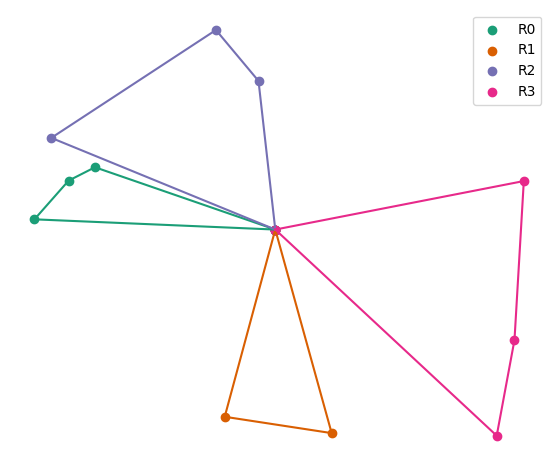

In [69]:
# Choosing colors
cmap = mpl.colormaps["Dark2"]
colors = cycle(cmap.colors)

# Now the figure
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
for r, tour in enumerate(tours):
    c = next(colors)
    t = np.array(tour)
    x = coordinates[t, 0]
    y = coordinates[t, 1]
    ax.scatter(x, y, color=c, label=f"R{r}")
    ax.plot(x, y, color=c)

ax.legend()
fig.tight_layout()
plt.axis('off')
plt.show()